In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
%matplotlib inline 

In [2]:
churn_df = pd.read_csv('./data/churn.csv')
col_names = churn_df.columns.tolist()

print("Column names:")
print(col_names)

to_show = col_names[:6] + col_names[-6:]

print("\nSample data:")
churn_df[to_show].head(10)

Column names:
['State', 'Account Length', 'Area Code', 'Phone', "Int'l Plan", 'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls', 'Churn?']

Sample data:


,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,8.41,10.1,3,2.73,3,False.
5,AL,118,510,391-8027,yes,no,9.18,6.3,6,1.70,0,False.
6,MA,121,510,355-9993,no,yes,9.57,7.5,7,2.03,3,False.
7,MO,147,415,329-9001,yes,no,9.53,7.1,6,1.92,0,False.
8,LA,117,408,335-4719,no,no,9.71,8.7,4,2.35,1,False.
9,WV,141,415,330-8173,yes,yes,14.69,11.2,5,3.02,0,False.


In [3]:
# Dependent Var
churn_result = churn_df['Churn?']
y = np.where(churn_result == 'True.',1,0)

In [4]:
# Dropping columns
to_drop = ['State','Area Code','Phone','Churn?']
churn_feat_space = churn_df.drop(to_drop,axis=1)

In [5]:
# 'yes'/'no' has to be converted to boolean values
# NumPy converts these from boolean to 1. and 0. later
yes_no_cols = ["Int'l Plan","VMail Plan"]
churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'

In [6]:
# Pull out features for future use
features = churn_feat_space.columns
print(features)

Index(['Account Length', 'Int'l Plan', 'VMail Plan', 'VMail Message',
       'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls',
       'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins',
       'Intl Calls', 'Intl Charge', 'CustServ Calls'],
      dtype='object')


In [7]:
X = churn_feat_space.to_numpy().astype(np.float)

# This is important
scaler = StandardScaler()
X = scaler.fit_transform(X)
print("Feature space holds %d observations and %d features" % X.shape)
print("Unique target labels:", np.unique(y))

Feature space holds 3333 observations and 17 features
Unique target labels: [0 1]


In [8]:
def run_cv(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_splits=2,shuffle=True)
    y_pred = y.copy()
    
    # Iterate through folds
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
    return y_pred

In [9]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.metrics import average_precision_score

def accuracy(y_true,y_pred):
    # NumPy interpretes True and False as 1. and 0.
    return np.mean(y_true == y_pred)

In [10]:
print("Logistic Regression:")
print("%.3f" % accuracy(y, run_cv(X,y,LR)))

Logistic Regression:
0.861


In [ ]:
print("Gradient Boosting Classifier")
print("%.3f" % accuracy(y, run_cv(X,y,GBC)))

In [ ]:
print("Support vector machines:")
print("%.3f" % accuracy(y, run_cv(X,y,SVC)))

In [ ]:
print("Random forest:")
print("%.3f" % accuracy(y, run_cv(X,y,RF)))

In [11]:
print("K-nearest-neighbors:")
print("%.3f" % accuracy(y, run_cv(X,y,KNN)))

K-nearest-neighbors:
0.895


[[2805   45]
 [ 304  179]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


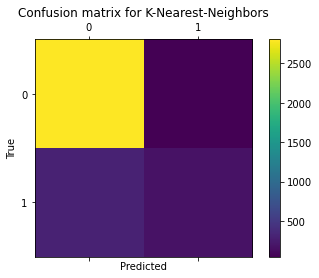

[[2769   81]
 [ 382  101]]


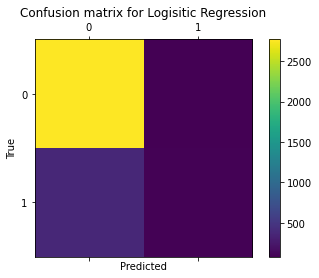

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def draw_confusion_matrices(confusion_matricies,class_names):
    class_names = class_names.tolist()
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        print(cm)
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm)
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    
y = np.array(y)
class_names = np.unique(y)

confusion_matrices = [
    ( "K-Nearest-Neighbors", confusion_matrix(y,run_cv(X,y,KNN)) ),
    ( "Logisitic Regression", confusion_matrix(y,run_cv(X,y,LR)) )
]

# Pyplot code not included to reduce clutter
# from churn_display import draw_confusion_matrices
%matplotlib inline

draw_confusion_matrices(confusion_matrices,class_names)

Feature ranking:
1. Account Length (0.143617)
2. Int'l Plan (0.134716)
3. VMail Plan (0.078417)
4. VMail Message (0.069265)
5. Day Mins (0.068907)
6. Day Calls (0.034400)
7. Day Charge (0.031323)
8. Eve Mins (0.029564)
9. Eve Calls (0.025768)
10. Eve Charge (0.022527)


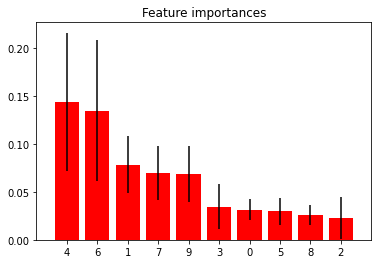

In [13]:
train_index,test_index = train_test_split(churn_df.index)

forest = RF()
forest_fit = forest.fit(X[train_index], y[train_index])
forest_predictions = forest_fit.predict(X[test_index])

importances = forest_fit.feature_importances_[:10]
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. %s (%f)" % (f + 1, features[f], importances[indices[f]]))

# Plot the feature importances of the forest
#import pylab as pl
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices], yerr=std[indices], color="r", align="center")
plt.xticks(range(10), indices)
plt.xlim([-1, 10])
plt.show()